# LOS Prediction

For CIHI insite, see this link: https://tableau.albertahealthservices.ca/#/workbooks/28259/views. It's based on a few items: 

    Comorbidity Level (COMORB_LVL): 0, 1, 2, 3, 4, 8
    Flagged Intervention Status (AHS_IP_PROJ_OPT_MISC_W_LLOYD.CIHI_FLG_INTERVENTION_STATUS): 
        FI Group 1: G, Q
        FI Group 2: E, H, J, M, N
        FI Group 3: A, B, C, D, F, I, K, L, O, P
    Intervention Event(AHS_IP_DOC_DX_INTVN_W_LLOYD.EVENT_CNT): 1 event, 2 events, 3+ events, 8 NA
    OOH status(PROCOOH1): Yes/No
    MCC: 
    CMG: 
    Age Category: For adult, 0, 1-7 Yrs, 8-17, 18-59, 60-79, 80+ Yrs


# 1. Read Data

In [199]:
import pandas as pd
import numpy as np
import os


In [200]:
import os
from os.path import join

joined_path = join(os.getcwd(), "elos_breakdown_lc.xlsx")
df_original = pd.read_excel(joined_path, sheet_name = 'data')
display(df_original.head(3))

,INST,ADMITCAT,PROCCODE1,PROCOOH1,AGE_ADMIT,MCC,CMG,CMG_AGEGRP,COMORB_LVL,EVENT_CNT,ELOS,RIW,ACUTE_DAYS,SEQNUM,CIHI_FLG_INTERVENTION_STATUS
0,80044,U,NaN,NaN,52,5,196,R,4,8,14.2,2.6451,15,8004420201205050,0.0
1,80043,U,5MD60AA,NaN,32,13,561,R,2,1,4.6,1.4110,3,8004320201228020,0.0
2,80043,L,5MD50AA,NaN,24,13,563,R,0,8,1.6,0.3963,1,8004320201228010,0.0


# 2. Exam Data

In [201]:
display(df_original.describe()) #process all the number columns
print(df_original.dtypes) #See each column's data type
print('-----')
display(df_original.dtypes.value_counts())

,INST,AGE_ADMIT,MCC,CMG,COMORB_LVL,EVENT_CNT,ELOS,RIW,ACUTE_DAYS,SEQNUM,CIHI_FLG_INTERVENTION_STATUS
count,95845.000000,95845.000000,95845.000000,95845.000000,95845.000000,95845.000000,95845.000000,95845.000000,95845.000000,9.584500e+04,77530.000000
mean,80043.373989,49.905086,10.495550,429.192290,1.202869,5.485273,6.250778,1.796436,6.657812,8.004358e+15,0.498929
std,0.483863,26.490650,6.051088,237.518279,2.088490,3.330006,8.354720,4.137360,13.402027,4.838641e+10,1.288421
min,80043.000000,0.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,8.004320e+15,0.000000
25%,80043.000000,32.000000,5.000000,209.000000,0.000000,1.000000,2.100000,0.503500,1.000000,8.004320e+15,0.000000
50%,80043.000000,54.000000,11.000000,460.000000,0.000000,8.000000,3.600000,0.896600,3.000000,8.004320e+15,0.000000
75%,80044.000000,70.000000,14.000000,595.000000,2.000000,8.000000,6.900000,1.666300,7.000000,8.004420e+15,0.000000
max,80044.000000,999.000000,99.000000,999.000000,8.000000,8.000000,100.000000,235.500000,625.000000,8.004420e+15,8.000000


INST                              int64
ADMITCAT                         object
PROCCODE1                        object
PROCOOH1                         object
AGE_ADMIT                         int64
MCC                               int64
CMG                               int64
CMG_AGEGRP                       object
COMORB_LVL                        int64
EVENT_CNT                         int64
ELOS                            float64
RIW                             float64
ACUTE_DAYS                        int64
SEQNUM                            int64
CIHI_FLG_INTERVENTION_STATUS    float64
dtype: object
-----


int64      8
object     4
float64    3
dtype: int64

### Data Process Needed

Rows to be processed

    ELOS: delete values >=90
    
Columns to be deleted

    SEQNUM
    ACUTE_DAYS                        
    INST (maybe)
    
What should have been object? 

    INST (if not deleted)
    MCC
    CMG
    COMORB_LVL
    CIHI_FLG_INTERVENTION_STATUS
    EVENT_CNT
   
    
Column to be processed

    PROCCODE1 - take the first character only (maybe not)
    AGE_ADMIT - convert to numeric then into category
    PROCOOH1 - convert to integer with values of 1 or 0
    
    
    

In [202]:
print(df.dtypes)

ELOS                            float64
ADMITCAT                         object
PROCOOH1                          Int64
MCC                              object
CMG                              object
CMG_AGEGRP                       object
COMORB_LVL                       object
EVENT_CNT                        object
RIW                             float64
CIHI_FLG_INTERVENTION_STATUS     object
AGE_CAT                          object
dtype: object


In [203]:
df= df_original.copy()
df = df[ (df['ELOS'] < 90) ] #filter data by value
df = df[(df['AGE_ADMIT']>=1)]                        
df = df.drop(['SEQNUM', 'ACUTE_DAYS', 'INST','PROCCODE1'], axis=1)


def age_group_func(x): 
    if x >=80: 
        result = '80+'
    elif x>=60: 
        result = '60-79'
    elif x>=18: 
        result = '18-59'
    elif x>=8: 
        result = '8-17'
    else: 
        result = '1-7'
    return result

df['AGE_CAT'] = df.apply(lambda row: age_group_func(row["AGE_ADMIT"]),axis=1)
df = df.drop(['AGE_ADMIT'], axis=1)

def procooh_convt_func(x): 
    if x == 'Yes': 
        result = 1
    else: 
        result = 0
    return result

df['PROCOOH1'] = df.apply(lambda row: procooh_convt_func(row["PROCOOH1"]),axis=1).astype('Int64')

df['CIHI_FLG_INTERVENTION_STATUS'] = df['CIHI_FLG_INTERVENTION_STATUS'].astype('Int64')
for col in ['MCC','CMG','COMORB_LVL','CIHI_FLG_INTERVENTION_STATUS','EVENT_CNT']: 
    df[col] = df[col].apply(str)
cols = list(df.columns.values)
cols = [x for x in cols if x !='ELOS']
cols = ['ELOS']+cols
df = df[cols]
df.head(3)


,ELOS,ADMITCAT,PROCOOH1,MCC,CMG,CMG_AGEGRP,COMORB_LVL,EVENT_CNT,RIW,CIHI_FLG_INTERVENTION_STATUS,AGE_CAT
0,14.2,U,0,5,196,R,4,8,2.6451,0,18-59
1,4.6,U,0,13,561,R,2,1,1.4110,0,18-59
2,1.6,L,0,13,563,R,0,8,0.3963,0,18-59


In [204]:
# # Review the y and see if it's very class imbalanced
# # print(df['ELOS'].value_counts(normalize=True))

# from matplotlib import pyplot as plt
# plt.hist(df['ELOS'], edgecolor='black')

# # it's very imbalanced

# 3. Process Feature Columns and the Target Column

# 3.2 Process the Feature Columns

## 3.2.1 Examine - is there any categorial(object) columns in the feature columns

In [205]:


# 3.2.1 Examine - is there any categorial(object) columns in the feature columns
feature_df = df.copy().drop(['ELOS'], axis=1)
display(feature_df.dtypes.head(10))
display(feature_df.head(3))

ADMITCAT                         object
PROCOOH1                          Int64
MCC                              object
CMG                              object
CMG_AGEGRP                       object
COMORB_LVL                       object
EVENT_CNT                        object
RIW                             float64
CIHI_FLG_INTERVENTION_STATUS     object
AGE_CAT                          object
dtype: object

,ADMITCAT,PROCOOH1,MCC,CMG,CMG_AGEGRP,COMORB_LVL,EVENT_CNT,RIW,CIHI_FLG_INTERVENTION_STATUS,AGE_CAT
0,U,0,5,196,R,4,8,2.6451,0,18-59
1,U,0,13,561,R,2,1,1.4110,0,18-59
2,L,0,13,563,R,0,8,0.3963,0,18-59


## 3.2.2 If there are some categorical(object) columns in the feature columns. Convert them to integer

In [206]:
# 3.2.2 If there are some categorical(object) columns in the feature columns. Convert them to integer
string_cols = feature_df.dtypes[feature_df.dtypes == np.object]  # filtering by string categoricals
string_cols = string_cols.index.tolist()  # list of categorical fields
for col in string_cols:
    feature_df[col] = pd.Categorical(feature_df[col])
# Do the one hot encoding
feature_df = pd.get_dummies(feature_df, columns=string_cols)
display(feature_df.head(1))

,PROCOOH1,RIW,ADMITCAT_L,ADMITCAT_U,MCC_1,MCC_10,MCC_11,MCC_12,MCC_13,MCC_15,...,CIHI_FLG_INTERVENTION_STATUS_5,CIHI_FLG_INTERVENTION_STATUS_6,CIHI_FLG_INTERVENTION_STATUS_7,CIHI_FLG_INTERVENTION_STATUS_8,CIHI_FLG_INTERVENTION_STATUS_<NA>,AGE_CAT_1-7,AGE_CAT_18-59,AGE_CAT_60-79,AGE_CAT_8-17,AGE_CAT_80+
0,0,2.6451,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [207]:
print(feature_df.dtypes)

# for col in ['MCC','CMG','COMORB_LVL','CIHI_FLG_INTERVENTION_STATUS','EVENT_CNT']: 
#     df[col] = df[col].apply(str)

PROCOOH1           Int64
RIW              float64
ADMITCAT_L         uint8
ADMITCAT_U         uint8
MCC_1              uint8
                  ...   
AGE_CAT_1-7        uint8
AGE_CAT_18-59      uint8
AGE_CAT_60-79      uint8
AGE_CAT_8-17       uint8
AGE_CAT_80+        uint8
Length: 539, dtype: object


## 3.2.3 Scale the Float Columns
### 3.2.3.1 Use StandardScaler, MinMaxScaler, MaxAbsScaler

In [208]:
# df = pd.read_csv('C:\\Users\\LC\\KnowledgeBase\\Data\\Wine_Quality_Data.csv', sep=',')
# feature_df = df.copy().drop(['ELOS'], axis=1)

# 3.2.3.1 Scale the float column by StandardScaler, MinMaxScaler...etc. 
float_cols = feature_df.columns[feature_df.dtypes == np.float]  
print(float_cols)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
feature_df[float_cols]= StandardScaler().fit_transform(feature_df[float_cols])

# alternatively if you want to transform all columns
# df = StandardScaler().fit_transform(df)
# df = pd.DataFrame(df, columns=df.columns)

Index(['RIW'], dtype='object')


# 4. Split Data - train_test_split or StratifiedShuffleSplit

## 4.1 train_test_split

In [209]:
## 4.1 train_test_split
X_data = feature_df
X_data=np.asarray(X_data).astype(np.float32) 
y_data = df['ELOS'].values
y_data=np.asarray(y_data).astype(np.float32)

# import tensor
# #Considering y variable holds numpy array
# y_data = tensor.convert_to_tensor(y_data, dtype=tensor.int64) 

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_data, y_data, test_size=0.3, random_state=42)

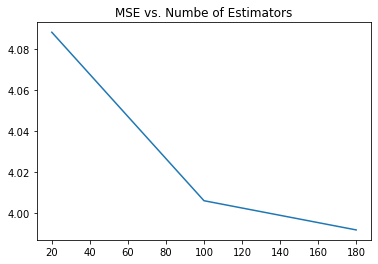

Best e value is 120
[4.08840266 4.00621655 3.99196508]


In [210]:
### 2.2.1 Parameter Tuning - RandomForestRegressor - identify the best n_estimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
scores = []
for e in range(10, 2000, 200): 
    R = RandomForestRegressor(n_estimators=e)
    score = cross_val_score(R, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error').mean()
    scores.append(score)
scores = -np.array(scores)


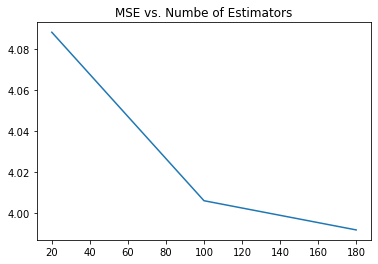

Best e value is 180
[4.08840266 4.00621655 3.99196508]


In [219]:
plt.plot(range(200, 2000, 200), scores)
plt.title('MSE vs. Numbe of Estimators')
plt.show()
best_e =200* (int(np.argmin(scores)))+200
print('Best e value is', best_e)
print(scores)

R = RandomForestRegressor(n_estimators=best_e)
score = cross_val_score(R, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error').mean()

The number of hidden neurons should be between the size of the input layer and the size of the output layer. Or

The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. Or 

The number of hidden neurons should be less than twice the size of the input layer.

In [211]:
print(X_train.shape[1])

539


In [212]:
### Tensorflow

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


print(tf.__version__)

# model = Sequential()
# model.add(Dense(X_train.shape[1]+1, input_shape=[X_train.shape[1]], kernel_initializer='normal', activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='linear'))  
# model.summary()
# model.compile(loss='mse', optimizer = Adam(learning_rate=0.1), metrics=['mse','mae']) #optimizer='rmsprop', #metrics='mae',
# history=model.fit(X_train, y_train, epochs=50, batch_size=150, verbose=1, validation_split=0.2)
# print("Final loss value:",model.evaluate(X_test, y_test))
# predictions = model.predict(X_train)

2.4.1


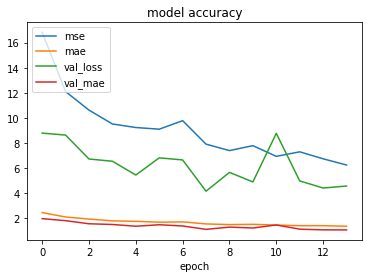

In [213]:
from matplotlib import pyplot as plt
plt.plot(history.history['mse'][5:])
plt.plot(history.history['mae'][5:])
plt.plot(history.history['val_loss'][5:])
plt.plot(history.history['val_mae'][5:])
plt.title('model accuracy')
# plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['mse', 'mae', 'val_loss', 'val_mae'], loc='upper left')
plt.show()

In [214]:
print(feature_df.shape)

(85989, 539)


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 540)               291600    
_________________________________________________________________
dropout_20 (Dropout)         (None, 540)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 4096)              2215936   
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 4097      
Total params: 2,511,633
Trainable params: 2,511,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
377/377 [==============================] - 14s 35ms/step - loss: 265949.4617 - mse: 265949.4617 - mae: 67.2029 - val_loss: 10.3260 - val_mse: 10.3260 - val_mae: 1.4152
Epoch 2/50
377/377 [==============================] - 13s 34ms

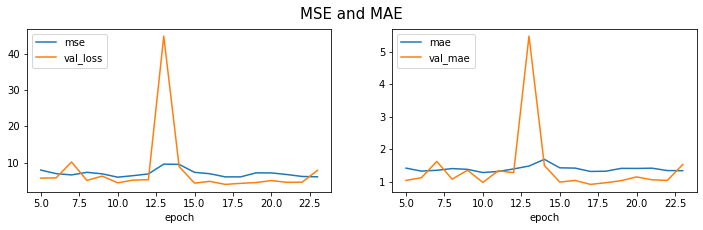

In [215]:
model = Sequential()
model.add(Dense(X_train.shape[1]+1, 
                input_shape=[X_train.shape[1]], 
                kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))  
model.summary()
model.compile(loss='mse', optimizer = Adam(learning_rate=0.1), metrics=['mse','mae']) #optimizer='rmsprop', #metrics='mae',
early_stop = EarlyStopping(monitor='val_loss', 
#                            mode='min', 
                           verbose=1, patience=6)
history=model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=1, validation_split=0.2, callbacks=[early_stop])
print("Final loss value:",model.evaluate(X_test, y_test))
# predictions = model.predict(X_train)

from matplotlib import pyplot as plt
n = 5
fig = plt.figure(figsize = (12,3))
plt.suptitle('MSE and MAE', fontsize = 15)
ax1 = fig.add_subplot(121)
plt.plot([i for i in range(n, len(history.history['mse']))], history.history['mse'][n:])
plt.plot([i for i in range(n, len(history.history['mse']))], history.history['val_loss'][n:])
plt.xlabel('epoch')
plt.legend(['mse',  'val_loss'], loc='upper left')

ax2 = fig.add_subplot(122)
plt.plot([i for i in range(n, len(history.history['mse']))], history.history['mae'][n:])
plt.plot([i for i in range(n, len(history.history['mse']))], history.history['val_mae'][n:])
plt.xlabel('epoch')
plt.legend(['mae',  'val_mae'], loc='upper left')

In [229]:
# serialize model to JSON
model_json = model.to_json()
with open("neural_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("neural_model.h5")
print("Saved model to disk")
 

 
# To load json and create model
json_file = open('neural_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
print('done')

from tensorflow.keras.models import model_from_json
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("neural_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.1), metrics=['mse', 'mae'])  #optimizer = 'rmsprop'
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print(loaded_model.metrics_names[1], score[1])

Saved model to disk
done
Loaded model from disk
('mse', 7.893083095550537)
